In [1]:
%pylab inline
from pygadgetreader import *
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:841: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/ngaravito/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())


Populating the interactive namespace from numpy and matplotlib


# Computing the CM 

## Basic approach:

In [2]:
# Random points in a sphere:

r = random.random(1000) 
theta = random.random(1000) * 2 - 1
phi = random.random(1000) * 2 * np.pi

x1 = r**(1/3.0) * sin(arccos(theta)) * sin(phi)
y1 = r**(1/3.0) * sin(arccos(theta)) * cos(phi)
z1 = r**(1/3.0) * theta

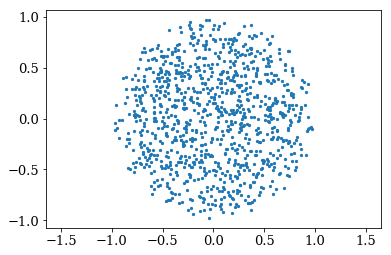

In [3]:
axis('equal')
scatter(x1, z1, s=5)

In [4]:
# CM coordinates:
xCM = sum(x1)/len(x1)
yCM = sum(y1)/len(y1)
zCM = sum(z1)/len(z1)

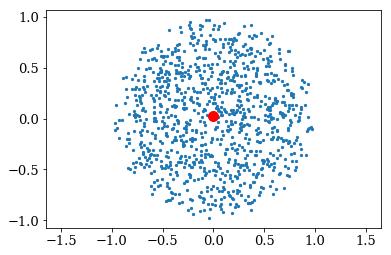

In [5]:
axis('equal')
scatter(x1, z1, s=5)
scatter(xCM, zCM, s=100, c='r')

## Iterative approach:


In [6]:
def CM(x, y, z, vx, vy, vz, delta):
    N_i = len(x)
    N = N_i
    xCM = sum(x)/len(x)
    yCM = sum(y)/len(y)
    zCM = sum(z)/len(z)

    xCM_new = xCM
    yCM_new = yCM
    zCM_new = zCM
    
    xCM = 0.0
    yCM = 0.0
    zCM = 0.0
    
    vxCM_new = sum(vx)/N
    vyCM_new = sum(vy)/N
    vzCM_new = sum(vz)/N
    R1 = np.sqrt((x - xCM_new)**2 + (y - yCM_new)**2 + (z - zCM_new)**2)
    Rnow = [max(R1)]

    while ((np.sqrt((xCM_new-xCM)**2 + (yCM_new-yCM)**2 +(zCM_new-zCM)**2) > delta)  & ((N>N_i*0.01))):
        xCM = xCM_new#[-1]
        yCM = yCM_new#[-1]
        zCM = zCM_new#[-1]
        R = np.sqrt((x - xCM)**2 + (y - yCM)**2 + (z - zCM)**2)
        Rmax = max(R)
        index = where(R<Rmax*0.975)
        x = x[index]
        y = y[index]
        z = z[index]
        vx = vx[index]
        vy = vy[index]
        vz = vz[index]
        N = len(x)
        xCM_new=(sum(x)/N)
        yCM_new=(sum(y)/N)
        zCM_new=(sum(z)/N)
        vxCM_new=(sum(vx)/N)
        vyCM_new=(sum(vy)/N)
        vzCM_new=(sum(vz)/N)
        #Rnow.append(max(np.sqrt((x - xCM_new[-1])**2 + (y - yCM_new[-1])**2 + (z - zCM_new[-1])**2)))

        #scatter(xCM_new, yCM_new)

    #print N
    return xCM_new, yCM_new, zCM_new, vxCM_new, vyCM_new, vzCM_new#, Rnow

In [24]:
def CM_disk_potential(x, y, z, vx, vy, vz, Pdisk):
    min_pot = np.where(Pdisk==min(Pdisk))[0]
    x_min = x[min_pot]
    y_min = y[min_pot]
    z_min = z[min_pot]
    avg_particles = np.where(np.sqrt((x-x_min)**2.0 + (y-y_min)**2.0 + (z-z_min)**2.0)<2.0)[0]
    x_cm = sum(x[avg_particles])/len(avg_particles)
    y_cm = sum(y[avg_particles])/len(avg_particles)
    z_cm = sum(z[avg_particles])/len(avg_particles)
    vx_cm = sum(vx[avg_particles])/len(avg_particles)
    vy_cm = sum(vy[avg_particles])/len(avg_particles)
    vz_cm = sum(vz[avg_particles])/len(avg_particles)
    return x_cm, y_cm, z_cm, vx_cm, vy_cm, vz_cm

In [25]:
def MW_LMC_particles(xyz, vxyz, pids, NMW_particles):
    sort_indexes = np.sort(pids)         
    N_cut = sort_indexes[NMW_particles]
    MW_ids = np.where(pids<N_cut)[0]  
    MW_ids = np.where(pids<N_cut)[0]  
    return xyz[MW_ids], vxyz[MW_ids], xyz[LMC_ids], vxyz[LMC_ids]  

In [26]:
def computing_MW_CM(path, snap, i_n, i_f, Nhost):
    N_snaps = (i_f - i_n) + 1

    X = np.zeros(N_snaps)
    Y = np.zeros(N_snaps)
    Z = np.zeros(N_snaps)

    VX = np.zeros(N_snaps)
    VY = np.zeros(N_snaps)
    VZ = np.zeros(N_snaps)
    
    XLMC = np.zeros(N_snaps)
    YLMC = np.zeros(N_snaps)
    ZLMC = np.zeros(N_snaps)

    VXLMC = np.zeros(N_snaps)
    VYLMC = np.zeros(N_snaps)
    VZLMC = np.zeros(N_snaps)
    
    Xd = np.zeros(N_snaps)
    Yd = np.zeros(N_snaps)
    Zd = np.zeros(N_snaps)

    VXd = np.zeros(N_snaps)
    VYd = np.zeros(N_snaps)
    VZd = np.zeros(N_snaps)

    time = np.zeros(N_snaps)

    for i in range(i_n, i_f + 1):
        #print 'snapshot' + str(i)
        time[i-i_n] = readheader(path + snap + "_{:0>3d}".format(i) ,'time')
        positions = readsnap(path + snap + "_{:0>3d}".format(i) ,'pos', 'dm')
        velocities = readsnap(path + snap + "_{:0>3d}".format(i), 'vel', 'dm')
        particles_ids = readsnap(path + snap + "_{:0>3d}".format(i), 'pid', 'dm')
        potential = readsnap(path + snap + "_{:0>3d}".format(i), 'pot', 'disk')
        positions_d = readsnap(path + snap + "_{:0>3d}".format(i),'pos', 'disk')
        v_d = readsnap(path + snap + "_{:0>3d}".format(i),'vel', 'disk')


        ID = np.sort(particles_ids)
        # The first set of particles are from the host DM halo, the
        # second set are from the satellite DM halo, the limit is know by
        # the number of particles in the host halo.
        idcut = ID[Nhost-1]
        index_mw = np.where(particles_ids<=idcut)
        index_LMC = np.where(particles_ids>idcut)

        x_mw = positions[index_mw[0],0]
        y_mw = positions[index_mw[0],1]
        z_mw = positions[index_mw[0],2]
        x_lmc = positions[index_LMC[0],0]
        y_lmc = positions[index_LMC[0],1]
        z_lmc = positions[index_LMC[0],2]

        vx_mw = velocities[index_mw[0],0]
        vy_mw = velocities[index_mw[0],1]
        vz_mw = velocities[index_mw[0],2]
        vx_lmc = velocities[index_LMC[0],0]
        vy_lmc = velocities[index_LMC[0],1]
        vz_lmc = velocities[index_LMC[0],2]
        
        X[i-i_n], Y[i-i_n], Z[i-i_n], VX[i-i_n], VY[i-i_n], VZ[i-i_n] = CM(x_mw, y_mw, z_mw, vx_mw, vy_mw, vz_mw, 0.01)
        Xd[i-i_n], Yd[i-i_n], Zd[i-i_n], VXd[i-i_n], VYd[i-i_n], VZd[i-i_n] =\
        CM_disk_potential(positions_d[:,0], positions_d[:,1], positions_d[:,2]\
                          , v_d[:,0], v_d[:,1], v_d[:,2], potential)
        #XLMC[i-i_n], YLMC[i-i_n], ZLMC[i-i_n], VXLMC[i-i_n], VYLMC[i-i_n], VZLMC[i-i_n] = CM(x_lmc, y_lmc, z_lmc, vx_lmc, vy_lmc, vz_lmc, 0.05) 

    return X, Y, Z, VX, VY, VZ, Xd, Yd, Zd, VXd, VYd, VZd


# Testing the code in a simulation snapshot:

In [27]:
Xcm, Ycm, Zcm, VxCm, VyCm, VzCm, Xd, Yd, Zd, Vxd, Vyd, Vzd = computing_MW_CM('../../data/LMCMW/MWmLMC6/H1/', 'MWfLMC6H1', 0, 100, 100000)


Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Positions
Returnin

(0, 25)

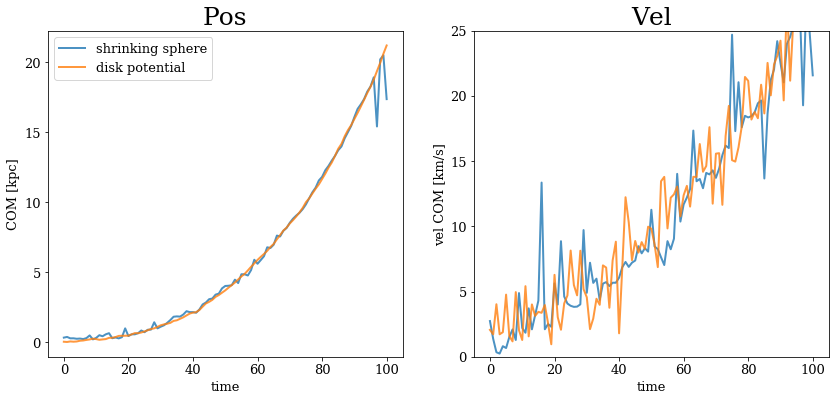

In [28]:
time = np.linspace(0, 2, 100)
figure(figsize=(14,6))
subplot(1, 2, 1)
title('Pos', fontsize=25)
plt.plot(np.sqrt(Xcm**2.0 + Ycm**2.0 + Zcm**2.0), lw=2, alpha=0.8, label='shrinking sphere')
plt.plot(np.sqrt(Xd**2.0 + Yd**2.0 + Zd**2.0), lw=2, alpha=0.8, label='disk potential')
xlabel('time')
ylabel('COM [kpc]')
legend()

subplot(1, 2, 2)
title('Vel', fontsize=25)
plt.plot(np.sqrt(VxCm**2.0 + VyCm**2.0 + VzCm**2.0), lw=2, alpha=0.8)
plt.plot(np.sqrt(Vxd**2.0 + Vyd**2.0 + Vzd**2.0), lw=2, alpha=0.8)
xlabel('time')
ylabel('vel COM [km/s]')
ylim(0, 25)

# Comparing the same snapshot with different resolution, Comparisson with the potential method

In [35]:
Xcm, Ycm, Zcm, VxCm, VyCm, VzCm, Xd, Yd, Zd, Vxd, Vyd, Vzd = computing_MW_CM('../../data/LMCMW/MW1LMC4/a1/', 'MW1LMC4a1H6', 0, 10, 100000)


Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities


IndexError: index 99999 is out of bounds for axis 0 with size 60000

In [30]:
pothalo1, poshalo1, velhalo1, idhalo1, potdisk1, posdisk1, veldisk1 = loading_data("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000")
pothalo2, poshalo2, velhalo2, idhalo2, potdisk2, posdisk2, veldisk2 = loading_data("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000")
pothalo3, poshalo3, velhalo3, idhalo3, potdisk3, posdisk3, veldisk3 = loading_data("MW1LMC4_a1H6UHR_000")

Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities


# Poisson Noise

$\dfrac{\sigma_x}{\sqrt{N}}$

following http://adsabs.harvard.edu/abs/2013ApJ...762..109B

In [154]:
def poissonN(x, y, z):
    #R = np.sqrt(x**2 + y**2 + z**2)
    pn = np.zeros(700)
    pn[0] = np.std(x)/ np.sqrt(len(x))
    Xmax = np.zeros(700)
    Xmax[0] = max(abs(x))
    i=0
    while len(x)>3:
        i+=1
        low_s = np.where(abs(x) <= 0.8*max(abs(x)))[0]
        #x = x[low_s]
        x = x[low_s]
        Xmax[i] = max(x)
        pn[i] = np.std(x) / (len(x)**(3.0/2.0)) # is this ok??
        
    index = np.where(pn!=0)[0]
    pn = pn[index]
    min_pn = np.where(pn == min(pn))
    return pn[index], Xmax[index]


In [155]:
PN1, Renclosed1 = poissonN(Xmwhalo1, Ymwhalo1, Zmwhalo1)
PN2, Renclosed2 = poissonN(Xmwhalo2, Ymwhalo2, Zmwhalo2)
PN3, Renclosed3 = poissonN(Xmwhalo3, Ymwhalo3, Zmwhalo3)

In [94]:
print type(Zmwhalo2)

<type 'numpy.ndarray'>


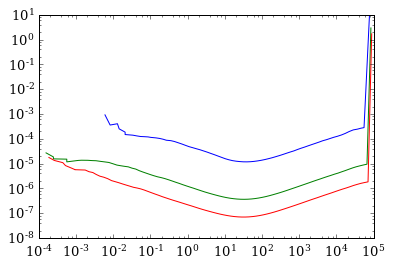

In [153]:
plot(Renclosed1, PN1)
plot(Renclosed2, PN2)
plot(Renclosed3, PN3)
xscale('log')
yscale('log')

In [135]:
print len(PN1)

70
